# Finalize sample

In this notebook, we finalize the LSBG sample, by doing the following:

- Get the latest galfitm results for (SExtractor measured quantities) `24.0 < mu_mean_g <24.3 mag/arcsec`$^2$ and `mu_mean_g > 24.3 mag/arcsec`$^2$.

- Correct for extinction.

- Include the large ($r_{1/2} > 20''$) galaxies.
 
- Reject those with $\langle \mu \rangle_e < 24.2''$ and $R_{eff} <2.5''$.

- Combine the two catalogs.

In [1]:
#Import stuff
import numpy as np 
import pandas as pd
from astropy.table import Table
from astropy.io import fits
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.special import gammainc # Note that the incomplete gamma function 
from scipy.optimize import root_scalar
from collections import OrderedDict
%matplotlib inline

#### Part I: Import the Galfit results - First those with `mu_mean_g > 24.3 mag/arcsec`$^2$.

In [2]:
Galfit_res_s = fits.open('y3_gold_2_2_lsbg_galfit_v4.6.fits')
# =========================================================
# =========================================================
# =========================================================
object_id_LSBGs = Galfit_res_s[1].data["COADD_OBJECT_ID"]
    
# Coordinates - Sextractor
RA = Galfit_res_s[1].data["RA"]
DEC = Galfit_res_s[1].data["DEC"]

# Coordinates - Galfit
RA_gf = Galfit_res_s[1].data["ALPHA_J2000"]
DEC_gf = Galfit_res_s[1].data["DELTA_J2000"]

# =========================================================
# =========================================================
# A, B image
A_IMAGE = Galfit_res_s[1].data["A_IMAGE"]
B_IMAGE = Galfit_res_s[1].data["B_IMAGE"]

# Define Ellipticity - Sextractor
Ell = 1.0 - B_IMAGE/A_IMAGE

# Axis ratio
AR = Galfit_res_s[1].data["AR"]
# Define Ellipticity - Galfit
Ell_gf = 1.0 - AR
#print(Ell-Ell_gf)

# ==========================================================
# ==========================================================
# Effective radius in g-band and error 
R_eff_g = 0.263*Galfit_res_s[1].data["RE_G"]
R_eff_g_err = 0.263*Galfit_res_s[1].data["RE_ERR_G"]
# Effective radius in r-band and error
R_eff_r = 0.263*Galfit_res_s[1].data["RE_R"]
R_eff_r_err = 0.263*Galfit_res_s[1].data["RE_ERR_R"]
# Effective radius in i-band and error
R_eff_i = 0.263*Galfit_res_s[1].data["RE_I"]
R_eff_i_err = 0.263*Galfit_res_s[1].data["RE_ERR_I"]
# ========================================================
# ========================================================

# Flux radius in g-band
flux_radius_g = 0.263*Galfit_res_s[1].data["FLUX_RADIUS_G"]
# Flux radius in r-band
flux_radius_r = 0.263*Galfit_res_s[1].data["FLUX_RADIUS_R"]
# Flux radius in i-band
flux_radius_i = 0.263*Galfit_res_s[1].data["FLUX_RADIUS_I"]
# ========================================================
# ========================================================
# Sersic index
n_ser = Galfit_res_s[1].data["N"]
n_ser_err = Galfit_res_s[1].data["N_ERR"]

# Galfitm Magnitudes
mag_gf_g = Galfit_res_s[1].data["MAG_G"]
mag_gf_r = Galfit_res_s[1].data["MAG_R"]
mag_gf_i = Galfit_res_s[1].data["MAG_I"]


# Galfitm Magnitude errors
magerr_gf_g = Galfit_res_s[1].data["MAG_ERR_G"]
magerr_gf_r = Galfit_res_s[1].data["MAG_ERR_R"]
magerr_gf_i = Galfit_res_s[1].data["MAG_ERR_I"]

# SExtractor (MAG_AUTO) magnitudes
mag_auto_g = Galfit_res_s[1].data["MAG_AUTO_G"]
mag_auto_r = Galfit_res_s[1].data["MAG_AUTO_R"]
mag_auto_i = Galfit_res_s[1].data["MAG_AUTO_I"]

# MAG_AUTO magnitude errors
magerr_auto_g = Galfit_res_s[1].data["MAGERR_AUTO_G"]
magerr_auto_r = Galfit_res_s[1].data["MAGERR_AUTO_R"]
magerr_auto_i = Galfit_res_s[1].data["MAGERR_AUTO_I"]
# ====================================================
# ====================================================
# mean surface brightness, SExtractor
mu_mean_mod_g = Galfit_res_s[1].data["MU_MEAN_MODEL_G"]
mu_mean_mod_r = Galfit_res_s[1].data["MU_MEAN_MODEL_R"]
mu_mean_mod_i = Galfit_res_s[1].data["MU_MEAN_MODEL_I"]
# =====================================================
# =====================================================

# Chi-squared values
chi2_g = Galfit_res_s[1].data['CHI2NU_G']
chi2_r = Galfit_res_s[1].data['CHI2NU_R']
chi2_i = Galfit_res_s[1].data['CHI2NU_I']
# ======================================================
# Extinction value
ext =  Galfit_res_s[1].data['EBV_SFD98']

print(len(RA))

21292


##### Correct the magnitudes for extinction

I will correct the magnitudes for galaxy extinction, based on the following conversions:

mag_g = mag_g - 3.186$\times$ebv_sfd98

mag_r = mag_r - 2.140$\times$ebv_sfd98

mag_i = mag_i - 1.569$\times$ebv_sfd98

In [3]:
# Correct the galfit magnitudes
mag_gf_g_cor = mag_gf_g - 3.186*ext
mag_gf_r_cor = mag_gf_r - 2.140*ext
mag_gf_i_cor = mag_gf_i - 1.569*ext

# Correct the mag_auto magnitudes
mag_auto_g_cor = mag_auto_g - 3.186*ext
mag_auto_r_cor = mag_auto_r - 2.140*ext
mag_auto_i_cor = mag_auto_i - 1.569*ext

# Correct the mu_mean_model
mu_mean_mod_g_cor = mu_mean_mod_g - 3.186*ext
mu_mean_mod_r_cor = mu_mean_mod_r - 2.140*ext
mu_mean_mod_i_cor = mu_mean_mod_i - 1.569*ext

### Mean and central surface brightness calculations

The mean surface brightness can be calculated from the effective radius and the magnitude as:

\begin{equation}
\left\langle \mu \right\rangle_{eff} = m + 2.5\log (2\pi \frac{\beta}{\alpha} R_{eff}^2)
\end{equation}

Where in $m$ we use the extinction-corrected apparent magnitude in each one of the three bands, $g, r, i$.



In [7]:
# mean surface brightness in g-band
mu_mean_g = mag_gf_g_cor + 2.5*np.log10(2.0*np.pi*AR*(R_eff_g**2.0))
# mean surface brightness in r-band
mu_mean_r = mag_gf_r_cor + 2.5*np.log10(2.0*np.pi*AR*(R_eff_r**2.0))
# mean surface brightness in i-band
mu_mean_i = mag_gf_i_cor + 2.5*np.log10(2.0*np.pi*AR*(R_eff_i**2.0))


mu_old = mag_gf_g_cor + 2.5*np.log10(2.0*np.pi*(R_eff_g**2.0))

diff = 2.5*np.log10(AR)

##### Explore the difference between the old and new definitions 

-0.3871823
-0.3340834


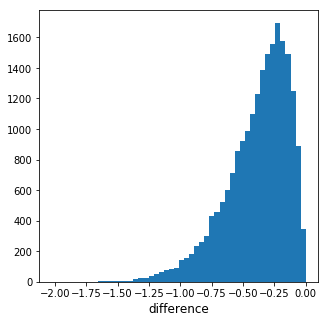

In [13]:
print(np.mean(diff))
print(np.median(diff))

plt.figure(figsize = (5.0,5.0))

plt.hist(diff,bins=50)
plt.xlabel('difference',fontsize=12)
plt.show()

In [63]:
from matplotlib import gridspec
from scipy.stats import gaussian_kde

def jointPlot(data_1, data_2, dims,cols,bins,kde=False,**kwargs):
    '''
    data = our dataset - dimensions (:,2) or (:,4) depending on the dimension
    dims = 2 or 4 - 2 in case we have a joint plot of one type of data - 4 if we have two types of data
    cols = colors (1 or 2)
    '''
    # ============================================================
    # ============================================================
    # Define the max and mins of the first dataset
    x_min_1, x_max_1 = data_1[:,0].min(),data_1[:,0].max()
    y_min_1, y_max_1 = data_1[:,1].min(),data_1[:,1].max()
    
    # Now if dims = 4, find the min and max of the second dataset as well
    if (dims==4):
        x_min_2, x_max_2 = data_2[:,0].min(),data_2[:,0].max()
        y_min_2, y_max_2 = data_2[:,1].min(),data_2[:,1].max()
    
    # ============================================================
    # ============================================================
    # Define grid for subplots
    gs = gridspec.GridSpec(2, 2,wspace=0.2,hspace=0.2, width_ratios=[4, 1], height_ratios = [1, 4])
    
    # ============================================================
    # ============================================================
    #Create scatter plot
    fig = plt.figure(figsize=(6.2,5.5),facecolor='white')
    ax = plt.subplot(gs[1, 0],frameon = True)
    cax = ax.scatter(data_1[:,0], data_1[:,1],rasterized=True, color=cols[0], s=0.7, alpha=.6)
    # Now in case dims=4, add one more scatter plot
    if (dims==4):
        cax = ax.scatter(data_2[:,0], data_2[:,1], rasterized=True,color=cols[1], s=0.7, alpha=.6)
   
    ax.grid(ls='--', axis='both' ,alpha=0.7)
    
    ax.set_xlabel(kwargs['xlabel'],fontsize=13)
    ax.set_ylabel(kwargs['ylabel'],fontsize=13)
    # ===============================================================
    # ===============================================================
    # Lower and upper limits in the x and y directions
    x_low = kwargs['xlow']
    x_up = kwargs['xup']
    y_low = kwargs['ylow']
    y_up = kwargs['yup']
    # ===============================================================
    # ===============================================================
    #Create Y-marginal (right)
    axr = plt.subplot(gs[1, 1], sharey=ax, frameon = True, xticks = [],ylim=(y_low,y_up)) 
    axr.hist(data_1[:,1],bins=bins, color = 'forestgreen',alpha=0.9, orientation = 'horizontal', density = True)
    # In case dims = 4, add one more historgram
    if (dims==4):
        axr.hist(data_2[:,1],bins=bins, color = cols[1],alpha=0.6, orientation = 'horizontal', density = True)
        
    
    axr.grid(ls='--', axis='both' ,alpha=0.6)
    
    
    # ===============================================================
    #Create X-marginal(top)
    axt = plt.subplot(gs[0,0], sharex=ax,frameon = True, yticks=[],xlim=(x_low,x_up))
    axt.hist(data_1[:,0],bins=bins, color = 'forestgreen',alpha=0.9, density = True)
    # In case dims = 4, add one more histogram
    if (dims==4):
        axt.hist(data_2[:,0],bins=bins, color = cols[1],alpha=0.6, density = True)
        
    axt.grid(ls='--', axis='both' ,alpha=0.6)
    
    #Bring the marginals closer to the scatter plot
    fig.tight_layout(pad = 0.0)

    if kde:
        kdex_1=gaussian_kde(data_1[:,0])
        kdey_1=gaussian_kde(data_1[:,1])
        x_1= np.linspace(x_min_1,x_max_1,100)
        y_1= np.linspace(y_min_1,y_max_1,100)
        dx_1=kdex_1(x_1)
        dy_1=kdey_1(y_1)
        axr.plot(dy_1,y_1,color='k',linewidth=1.2)
        axt.plot(x_1,dx_1,color='k', linewidth=1.2)
        
        # And in case dims = 4, we have more kdes
        if (dims==4):
            kdex_2=gaussian_kde(data_2[:,0])
            kdey_2=gaussian_kde(data_2[:,1])
            x_2= np.linspace(x_min_2,x_max_2,100)
            y_2= np.linspace(y_min_2,y_max_2,100)
            dx_2=kdex_2(x_2)
            dy_2=kdey_2(y_2)
            axr.plot(dy_2,y_2,color='black', ls='--')
            axt.plot(x_2,dx_2,color='black', ls='--')
        
    return ax,axt,axr   

In [30]:
data_1 = np.zeros((len(mu_old),2))
data_1[:,1] = diff
data_1[:,0] = mu_old

data_2 = np.zeros([2,2])

In [55]:
# First I have to create a 2D histogram to get the values
n_x = 100
n_y = 100
x_vals = np.linspace(23,28,n_x)
y_vals = np.linspace(-2,0.2,n_y)

Y, X = np.meshgrid(x_vals,y_vals)
xy = np.vstack([Y.ravel(),X.ravel()])


from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.03, kernel='gaussian', metric='euclidean')
kde.fit(data_1)
# Evaluate on the xy map 
Z = np.exp(kde.score_samples(xy.T))
Z = Z.reshape(X.shape)

print(Z.max())

2.000666303860994


Let's plot the correlation between axis ratio/difference and surface brightness

In [56]:
plt.figure(figsize = (5.5,5.5))

plt.scatter(mu_old,diff,s=0.2)

plt.xlabel('mu_mean, old_definition [mag/arcsec^2]',fontsize=14)
plt.ylabel('difference [mag_arcsec^2]', fontsize=14)
plt.show()

RuntimeError: latex was not able to process the following string:
'mu_mean, old_definition [mag/arcsec^2]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/Dimitris/.matplotlib/tex.cache/0a68dac3ae174b04af9e4375a4021f33.tex
LaTeX2e <2016/03/31>
Babel <3.9r> and hyphenation patterns for 83 language(s) loaded.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2016/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2016/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 0a68dac3ae174b04af9e4375a4021f33.aux.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 \fontsize{14.000000}{17.500000}{\sffamily mu_
                                                  mean, old_definition [mag/...
No pages of output.
Transcript written on 0a68dac3ae174b04af9e4375a4021f33.log.




<Figure size 396x396 with 1 Axes>

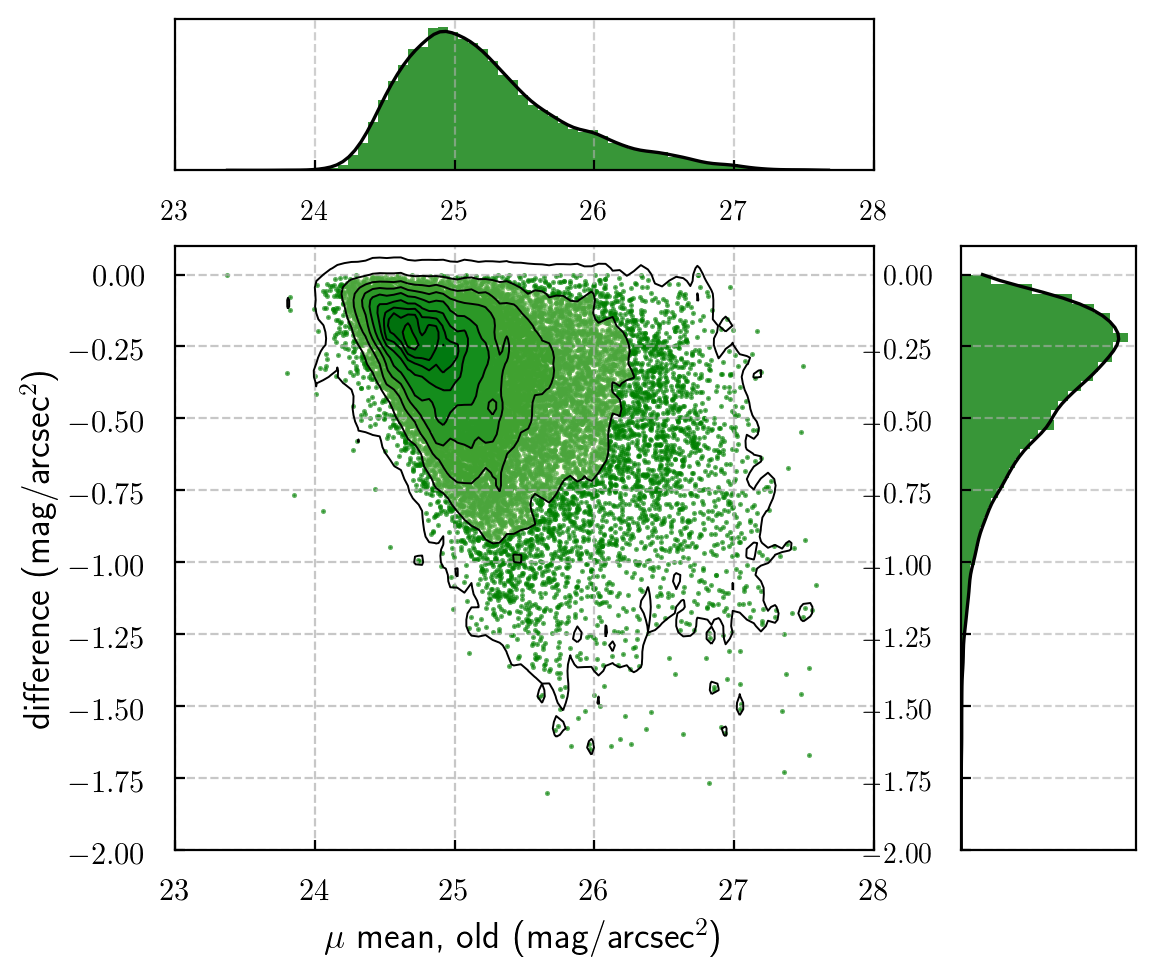

In [65]:
# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=8):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

props = dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.9)
props_2 = dict(boxstyle='round', facecolor='white',edgecolor='white', alpha=0.6)

#sns.set(style='whitegrid',font='serif',rc={'text.usetex' : True})
#sns.set_style({'xtick.bottom': True, 'xtick.top': True})
# Return ax object for extras
ax,axt,axr = jointPlot(data_1,data_2, dims=2,cols=['green'],bins=60,kde=True,xlabel='$\mu$ mean, old (mag/arcsec$^2$)', ylabel='difference (mag/arcsec$^2$)', xlow=23,xup=28,ylow=-2.,yup=0.1)
levels = np.linspace(0.015, Z.max(),11)
levels = [0.01,0.2,0.5,0.8,1.1,1.4,1.6,1.75, 1.9]
colors = ['k','k','k','k','k','k','k','k','k']
CS = ax.contour(Y,X, Z, levels=levels,colors=colors,linewidths=0.7)
CS = ax.contourf(Y,X, Z, levels=levels[1:], alpha=0.3,cmap='YlGn')

axr.tick_params(axis='both', labelsize=10)
axt.tick_params(axis='both', labelsize=10)


ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.savefig('diff_dist.png', dpi=100)
plt.show()

In [58]:
diff_loc = diff[mu_old<24.5]
print(np.median(diff_loc))

print(np.corrcoef(mu_old,diff))

-0.14147732
[[ 1.         -0.42867863]
 [-0.42867863  1.        ]]


For this part we will need to estimate the central surface brightness $\mu_0$. This is given by:

\begin{equation}
\mu_0 = \mu_e - \frac{2.5 b}{\ln(10)}
\end{equation}

$b$ can be calculated by solving the equation:

\begin{equation}
\Gamma(2n) = 2\gamma(2n,b),
\end{equation}
where:
\begin{equation}
\gamma(2n,x) = \int_0^x e^{-t}t^{2n-1} dt
\end{equation}
the incomplete gamma function.

Now, we have to estimate $\mu_e$. To do that we use the mean surface brightness, $\langle \mu \rangle_e$, calculated above.

We have that: 
\begin{equation}
\mu_e = \langle \mu \rangle_e + 2.5\log[f(n)]
\end{equation}

Where:
\begin{equation}
f(n) = \frac{ne^b}{b^{2n}}\Gamma(2n)
\end{equation}
and
\begin{equation}
\Gamma(2n) = \int_0^\infty e^{-x} x^{2n - 1} dx
\end{equation}


The final formula for $\mu_0$ is:

\begin{equation}
\mu_0 = \langle \mu \rangle_e + 2.5\log[f(n)] - \frac{2.5 b}{\ln(10)}
\end{equation}

with the needed parameters calculated as described above.

In [5]:
# First part, calculation of b for a given n. Write a function that does that.
def funct(x, *args):
    """
    The function to be minimized
    """
    n = args[0]
    fun = 2.0*gammainc(2.0*n,x) - 1.0
    return fun
    
def b_return(n):
    """
    This function returns the parameter b for a given
    Sersic index n, solving the equations described above
    """
    
    b_ret = root_scalar(funct, args=(n), method='bisect', bracket=[0.01, 40])
    return b_ret.root
    
b_n = np.zeros(len(n_ser))


for i in range(len(b_n)):
    b_n[i] = b_return(n_ser[i]) 

In [6]:
# Now calculate the function f(n)
f_n = (n_ser*np.exp(b_n)/(b_n**(2.0*n_ser)))*gamma(2.0*n_ser)

# Calculate central surface brightness for the three bands
# g-band first
mu_cent_g = mu_mean_g + 2.5*np.log10(f_n) -  2.5*b_n/np.log(10.0)
# r-band 
mu_cent_r = mu_mean_r + 2.5*np.log10(f_n) -  2.5*b_n/np.log(10.0)
# i-band
mu_cent_i = mu_mean_i + 2.5*np.log10(f_n) -  2.5*b_n/np.log(10.0)

#### Now perform the selection cuts

Reject those with $R_{eff} > 2.5''$ and $\langle \mu \rangle_e < 24.2''$, as measured through the galfit parameters.

Define the cuts first.

In [7]:
cuts = (mu_mean_g>=24.2)&(R_eff_g>=2.5)

In [8]:
# Coadd ids
coadd_n = object_id_LSBGs[cuts]

# Coordinates - Sextractor
RA_n = RA[cuts] 
DEC_n = DEC[cuts]
# Coordinates - Galfit
RA_gf_n = RA_gf[cuts]
DEC_gf_n = DEC_gf[cuts]
# ===========================================
# ===========================================
# A, B image
A_IMAGE_n = A_IMAGE[cuts]
B_IMAGE_n = B_IMAGE[cuts]

# Ellipticity - Sextractor
Ell_n = Ell[cuts]
# Ellipticity - Galfit
Ell_gf_n = Ell_gf[cuts]
# ===========================================
# ===========================================
# Effective Radii

# g-band
R_eff_g_n = R_eff_g[cuts]
R_eff_g_err_n = R_eff_g_err[cuts]
# r-band
R_eff_r_n = R_eff_r[cuts]
R_eff_r_err_n = R_eff_r_err[cuts]
# i-band
R_eff_i_n = R_eff_i[cuts]
R_eff_i_err_n = R_eff_i_err[cuts]
# ===========================================
# Flux Radii

# g-band
flux_radius_g_n = flux_radius_g[cuts]
# r-band
flux_radius_r_n = flux_radius_r[cuts]
# i-band
flux_radius_i_n = flux_radius_i[cuts]

# ===========================================
# ===========================================
# Sersic index 
n_ser_n = n_ser[cuts]
n_ser_err_n = n_ser_err[cuts]

# Galfit magnitudes
mag_gf_g_cor_n = mag_gf_g_cor[cuts]
mag_gf_r_cor_n = mag_gf_r_cor[cuts]
mag_gf_i_cor_n = mag_gf_i_cor[cuts]


# Galfit magnitude errors
magerr_gf_g_n = magerr_gf_g[cuts]
magerr_gf_r_n = magerr_gf_r[cuts]
magerr_gf_i_n = magerr_gf_i[cuts]


# MAG_AUTO magnitudes
mag_auto_g_cor_n = mag_auto_g_cor[cuts]
mag_auto_r_cor_n = mag_auto_r_cor[cuts]
mag_auto_i_cor_n = mag_auto_i_cor[cuts]

# MAG_AUTO magnitude errors
magerr_auto_g_n = magerr_auto_g[cuts]
magerr_auto_r_n = magerr_auto_r[cuts]
magerr_auto_i_n = magerr_auto_i[cuts]
# ============================================
# ============================================

# Extinction
ext_n = ext[cuts]
# ============================================
# ============================================
# mean surface 
mu_mean_g_n = mu_mean_g[cuts]
mu_mean_r_n = mu_mean_r[cuts]
mu_mean_i_n = mu_mean_i[cuts]

# Central surface 
mu_cent_g_n = mu_cent_g[cuts]
mu_cent_r_n = mu_cent_r[cuts]
mu_cent_i_n = mu_cent_i[cuts]

# ==============================================
# ==============================================
# mu_mean_model

# with extiction correction
mu_mean_mod_g_cor_n = mu_mean_mod_g_cor[cuts]
mu_mean_mod_r_cor_n = mu_mean_mod_r_cor[cuts]
mu_mean_mod_i_cor_n = mu_mean_mod_i_cor[cuts]

#without extinction correction
mu_mean_mod_g_n = mu_mean_mod_g[cuts]
mu_mean_mod_r_n = mu_mean_mod_r[cuts]
mu_mean_mod_i_n = mu_mean_mod_i[cuts]

# ============================================
# ============================================
# Chi-squared 
chi2_g_n = chi2_g[cuts]
chi2_r_n = chi2_r[cuts]
chi2_i_n = chi2_i[cuts]

print(len(n_ser_n))

20196


##### Exclude remaining bad objects

Now, exclude 6 remaining bad objects (there may be more, but these were the ones I was able to find).

In [9]:
bad_ids = [128602361,
          129395781,
          149763752,
          261926262,
          273410397,
          338312228,
          199492560,
          227222314,
          227913584,
          279057265]

Keep all, except these six.

In [10]:
# Create a mask
mask = np.isin(coadd_n,bad_ids)

In [11]:
# Coadd object id
object_id_f = coadd_n[~mask]

# ===============================================
# ===============================================
# RA and DEC - SExtractor
RA_f = RA_n[~mask]
DEC_f = DEC_n[~mask]
# RA and DEC - Galfit
RA_gf_f = RA_gf_n[~mask]
DEC_gf_f = DEC_gf_n[~mask]

# A, B image
A_IMAGE_f = A_IMAGE_n[~mask]
B_IMAGE_f = B_IMAGE_n[~mask]

# Ellipticity - SExtractor
Ell_f = Ell_n[~mask]
# Ellipticity - Galfit
Ell_gf_f = Ell_gf_n[~mask]
# ==============================================
# ==============================================
# Effective Radii

# g-band
R_eff_g_f = R_eff_g_n[~mask]
R_eff_g_err_f = R_eff_g_err_n[~mask]
# r-band
R_eff_r_f = R_eff_r_n[~mask]
R_eff_r_err_f = R_eff_r_err_n[~mask]
# i-band
R_eff_i_f = R_eff_i_n[~mask]
R_eff_i_err_f = R_eff_i_err_n[~mask]
# ============================================
# Flux Radii

# g-band
flux_radius_g_f = flux_radius_g_n[~mask]
# r-band
flux_radius_r_f = flux_radius_r_n[~mask]
# i-band
flux_radius_i_f = flux_radius_i_n[~mask]
# ============================================
# ============================================
# Sersic index 
n_ser_f = n_ser_n[~mask]
n_ser_err_f = n_ser_err_n[~mask]

# Galfit magnitudes
mag_gf_g_cor_f = mag_gf_g_cor_n[~mask]
mag_gf_r_cor_f = mag_gf_r_cor_n[~mask]
mag_gf_i_cor_f = mag_gf_i_cor_n[~mask]

# Galfit magnitude errors
magerr_gf_g_f = magerr_gf_g_n [~mask]
magerr_gf_r_f = magerr_gf_r_n [~mask]
magerr_gf_i_f = magerr_gf_i_n [~mask]

# MAG_AUTO magnitudes
mag_auto_g_cor_f = mag_auto_g_cor_n[~mask]
mag_auto_r_cor_f = mag_auto_r_cor_n[~mask]
mag_auto_i_cor_f = mag_auto_i_cor_n[~mask]

# MAG_AUTO magnitude errors
magerr_auto_g_f = magerr_auto_g_n[~mask]
magerr_auto_r_f = magerr_auto_r_n[~mask]
magerr_auto_i_f = magerr_auto_i_n[~mask]


extinction_f = ext_n[~mask]

# ============================================
# ============================================
# mean surface - galfit
mu_mean_g_f = mu_mean_g_n[~mask]
mu_mean_r_f = mu_mean_r_n[~mask]
mu_mean_i_f = mu_mean_i_n[~mask]

# Central surface - galfit
mu_cent_g_f = mu_cent_g_n[~mask]
mu_cent_r_f = mu_cent_r_n[~mask]
mu_cent_i_f = mu_cent_i_n[~mask]

# ==============================================
# =============================================
# First those with extinction correction
mu_mean_mod_g_cor_f = mu_mean_mod_g_cor_n[~mask]
mu_mean_mod_r_cor_f = mu_mean_mod_r_cor_n[~mask]
mu_mean_mod_i_cor_f = mu_mean_mod_i_cor_n[~mask]

# And now those without 
mu_mean_mod_g_f = mu_mean_mod_g_n[~mask]
mu_mean_mod_r_f = mu_mean_mod_r_n[~mask]
mu_mean_mod_i_f = mu_mean_mod_i_n[~mask]


# ============================================
# ============================================
# Chi-squared values
chi2_g_f = chi2_g_n[~mask]
chi2_r_f = chi2_r_n[~mask]
chi2_i_f = chi2_i_n[~mask]

print(len(n_ser_f))

20190


#### Part II: Import the Galfit results - First those with `24.0 < mu_mean_g < 24.3 mag/arcsec`$^2$.

In [12]:
Galfit_res_2 = fits.open('y3_gold_2_2_lsbg_galfit_v5.1.fits')

goodlist = fits.open('y3_v5.0_goodlist_v1.4.fits')
badlist = fits.open('y3_v5.0_badlist_v1.4.fits')
# ============================================================================
# ============================================================================
coadd_id_full = Galfit_res_2[1].data["COADD_OBJECT_ID"]
coadd_id_good = goodlist[1].data["COADD_OBJECT_ID"]
# Create a mask
mask_bright = np.isin(coadd_id_full,coadd_id_good)

In [13]:
# Coordinates - Sextractor
RA = Galfit_res_2[1].data["RA"]
DEC = Galfit_res_2[1].data["DEC"]

# Coordinates - Galfit
RA_gf = Galfit_res_2[1].data["ALPHA_J2000"]
DEC_gf = Galfit_res_2[1].data["DELTA_J2000"]

# =========================================================
# =========================================================
# A, B image
A_IMAGE = Galfit_res_2[1].data["A_IMAGE"]
B_IMAGE = Galfit_res_2[1].data["B_IMAGE"]

# Define Ellipticity - Sextractor
Ell = 1.0 - B_IMAGE/A_IMAGE

# Axis ratio
AR = Galfit_res_2[1].data["AR"]
# Define Ellipticity - Galfit
Ell_gf = 1.0 - AR
#print(Ell-Ell_gf)

# ==========================================================
# ==========================================================
# Effective radius in g-band and error 
R_eff_g = 0.263*Galfit_res_2[1].data["RE_G"]
R_eff_g_err = 0.263*Galfit_res_2[1].data["RE_ERR_G"]
# Effective radius in r-band and error
R_eff_r = 0.263*Galfit_res_2[1].data["RE_R"]
R_eff_r_err = 0.263*Galfit_res_2[1].data["RE_ERR_R"]
# Effective radius in i-band and error
R_eff_i = 0.263*Galfit_res_2[1].data["RE_I"]
R_eff_i_err = 0.263*Galfit_res_2[1].data["RE_ERR_I"]
# ========================================================
# ========================================================

# Flux radius in g-band
flux_radius_g = 0.263*Galfit_res_2[1].data["FLUX_RADIUS_G"]
# Flux radius in r-band
flux_radius_r = 0.263*Galfit_res_2[1].data["FLUX_RADIUS_R"]
# Flux radius in i-band
flux_radius_i = 0.263*Galfit_res_2[1].data["FLUX_RADIUS_I"]
# ========================================================
# ========================================================
# Sersic index
n_ser = Galfit_res_2[1].data["N"]
n_ser_err = Galfit_res_2[1].data["N_ERR"]

# =========================================================
# =========================================================
# Galfitm Magnitudes
mag_gf_g = Galfit_res_2[1].data["MAG_G"]
mag_gf_r = Galfit_res_2[1].data["MAG_R"]
mag_gf_i = Galfit_res_2[1].data["MAG_I"]


# Galfitm Magnitude errors
magerr_gf_g = Galfit_res_2[1].data["MAG_ERR_G"]
magerr_gf_r = Galfit_res_2[1].data["MAG_ERR_R"]
magerr_gf_i = Galfit_res_2[1].data["MAG_ERR_I"]

# SExtractor (MAG_AUTO) magnitudes
mag_auto_g = Galfit_res_2[1].data["MAG_AUTO_G"]
mag_auto_r = Galfit_res_2[1].data["MAG_AUTO_R"]
mag_auto_i = Galfit_res_2[1].data["MAG_AUTO_I"]

# MAG_AUTO magnitude errors
magerr_auto_g = Galfit_res_2[1].data["MAGERR_AUTO_G"]
magerr_auto_r = Galfit_res_2[1].data["MAGERR_AUTO_R"]
magerr_auto_i = Galfit_res_2[1].data["MAGERR_AUTO_I"]
# ====================================================
# ====================================================
# mean surface brightness, SExtractor
mu_mean_mod_g = Galfit_res_2[1].data["MU_MEAN_MODEL_G"]
mu_mean_mod_r = Galfit_res_2[1].data["MU_MEAN_MODEL_R"]
mu_mean_mod_i = Galfit_res_2[1].data["MU_MEAN_MODEL_I"]
# =====================================================
#Extinction
ext = Galfit_res_2[1].data['ebv_sfd98']

# =====================================================
# Chi-squared values
chi2_g = Galfit_res_2[1].data['CHI2NU_G']
chi2_r = Galfit_res_2[1].data['CHI2NU_R']
chi2_i = Galfit_res_2[1].data['CHI2NU_I']


print(len(RA[(mu_mean_mod_g>24.2)&(mu_mean_mod_g<24.3)]))
print(len(RA))

4159
13501


Keep only those that belong to the good ids list by masking.

In [14]:
# Mask the results
# =================================================
# =================================================
# Coadd object id
object_id_LSBGs_m = coadd_id_full[mask_bright]
# ==================================================
# Coordinates - SExtractor
RA_m = RA[mask_bright]
DEC_m = DEC[mask_bright]
# Coordinates- Galfit
RA_gf_m = RA_gf[mask_bright]
DEC_gf_m = DEC_gf[mask_bright]
# =================================================
# =================================================
# A, B image 
A_IMAGE_m = A_IMAGE[mask_bright]
B_IMAGE_m = B_IMAGE[mask_bright]


# Ellipticity SExtractor 
Ell_m = Ell[mask_bright]

#Axis ratio - Galfit
AR_m = AR[mask_bright]

# Ellipticity - Galfit
Ell_gf_m = Ell_gf[mask_bright]
# =================================================
# =================================================
# Effective radius in g-band and error 
R_eff_g_m = R_eff_g[mask_bright]
R_eff_g_err_m = R_eff_g_err[mask_bright]
# Effective radius in r-band and error
R_eff_r_m = R_eff_r[mask_bright]
R_eff_r_err_m = R_eff_r_err[mask_bright] 
# Effective radius in i-band and error
R_eff_i_m = R_eff_i[mask_bright]
R_eff_i_err_m = R_eff_i_err[mask_bright] 
# =================================================
# =================================================
# Flux radii

# g-band
flux_radius_g_m = flux_radius_g[mask_bright]
# r-band
flux_radius_r_m = flux_radius_r[mask_bright]
# i-band
flux_radius_i_m = flux_radius_i[mask_bright]
# ================================================
# ================================================
# Sersic index
n_ser_m = n_ser[mask_bright]
n_ser_err_m = n_ser_err[mask_bright]

# ================================================
# ================================================
# Galfitm Magnitudes
mag_gf_g_m = mag_gf_g[mask_bright]
mag_gf_r_m = mag_gf_r[mask_bright]
mag_gf_i_m = mag_gf_i[mask_bright]

# Galfitm Magnitude errors
magerr_gf_g_m = magerr_gf_g[mask_bright]
magerr_gf_r_m = magerr_gf_r[mask_bright]
magerr_gf_i_m = magerr_gf_i[mask_bright]

# SExtractor (MAG_AUTO) magnitudes
mag_auto_g_m = mag_auto_g[mask_bright]
mag_auto_r_m = mag_auto_r[mask_bright]
mag_auto_i_m = mag_auto_i[mask_bright]

# MAG_AUTO magnitude errors
magerr_auto_g_m = magerr_auto_g[mask_bright]
magerr_auto_r_m = magerr_auto_r[mask_bright]
magerr_auto_i_m = magerr_auto_i[mask_bright]
# ================================================
# ================================================
# mean surface brightness, SExtractor
mu_mean_mod_g_m = mu_mean_mod_g[mask_bright]
mu_mean_mod_r_m = mu_mean_mod_r[mask_bright]
mu_mean_mod_i_m = mu_mean_mod_i[mask_bright]
# =================================================
# =================================================

# Extinction
ext_m = ext[mask_bright]
# =================================================
# =================================================
# Chi-squared values
chi2_g_m = chi2_g[mask_bright]
chi2_r_m = chi2_r[mask_bright]
chi2_i_m = chi2_i[mask_bright]


print(len(RA_m[(mu_mean_mod_g_m>24.2)&(mu_mean_mod_g_m<24.3)]))

3440


In [15]:
print(len(n_ser_m))

11269


Correct the magnitudes for extinction

In [16]:
# Correct the galfit magnitudes
mag_gf_g_cor = mag_gf_g_m - 3.186*ext_m
mag_gf_r_cor = mag_gf_r_m - 2.140*ext_m
mag_gf_i_cor = mag_gf_i_m - 1.569*ext_m

# Correct the MAG AUTO magnitudes
mag_auto_g_cor = mag_auto_g_m - 3.186*ext_m
mag_auto_r_cor = mag_auto_r_m - 2.140*ext_m
mag_auto_i_cor = mag_auto_i_m - 1.569*ext_m

# Correct the mu_mean_model
mu_mean_mod_g_cor = mu_mean_mod_g_m - 3.186*ext_m
mu_mean_mod_r_cor = mu_mean_mod_r_m - 2.140*ext_m
mu_mean_mod_i_cor = mu_mean_mod_i_m - 1.569*ext_m

**Calculate mean and central surface brightness based on the galfit parameters**

In [17]:
# =====================================================================
# Mean surface brightnesses 


# mean surface brightness in g-band
mu_mean_g = mag_gf_g_cor + 2.5*np.log10(2.0*np.pi*AR_m*(R_eff_g_m**2.0))
# mean surface brightness in r-band
mu_mean_r = mag_gf_r_cor + 2.5*np.log10(2.0*np.pi*AR_m*(R_eff_r_m**2.0))
# mean surface brightness in i-band
mu_mean_i = mag_gf_i_cor + 2.5*np.log10(2.0*np.pi*AR_m*(R_eff_i_m**2.0))

# =======================================================================
# =======================================================================
# Calculation of central surface brightness

# First calculate some preliminary quantities
b_n = np.zeros(len(n_ser_m))
for i in range(len(b_n)):
    b_n[i] = b_return(n_ser_m[i]) 

# Now calculate the function f(n)
f_n = (n_ser_m*np.exp(b_n)/(b_n**(2.0*n_ser_m)))*gamma(2.0*n_ser_m)

# ========================================================================

# Calculate central surface brightness for the three bands
# g-band first
mu_cent_g = mu_mean_g + 2.5*np.log10(f_n) -  2.5*b_n/np.log(10.0)
# r-band 
mu_cent_r = mu_mean_r + 2.5*np.log10(f_n) -  2.5*b_n/np.log(10.0)
# i-band
mu_cent_i = mu_mean_i + 2.5*np.log10(f_n) -  2.5*b_n/np.log(10.0)

**Now, define and impose the surface brightness and effective radius cuts**

First define the cuts

In [18]:
# Define the cuts now
cuts_bright = (mu_mean_g>=24.2)&(R_eff_g_m>=2.5)

Now apply the cuts

In [19]:
# Coadd object ID
object_id_LSBGs_br = object_id_LSBGs_m[cuts_bright]

# ======================================================
# ======================================================
# Coordinates - SExtractor
RA_br = RA_m[cuts_bright]
DEC_br = DEC_m[cuts_bright]

# Coordinates- Galfit
RA_gf_br = RA_gf_m[cuts_bright]
DEC_gf_br = DEC_gf_m[cuts_bright]

# =================================================
# =================================================
# A, B image 
A_IMAGE_br = A_IMAGE_m[cuts_bright]
B_IMAGE_br = B_IMAGE_m[cuts_bright]

# Ellipticity SExtractor 
Ell_br = Ell_m[cuts_bright]

#Axis ratio - Galfit
AR_br = AR_m[cuts_bright]

# Ellipticity - Galfit
Ell_gf_br = Ell_gf_m[cuts_bright]
# =================================================
# =================================================
# Effective radius in g-band and error 
R_eff_g_br = R_eff_g_m[cuts_bright]
R_eff_g_err_br = R_eff_g_err_m[cuts_bright]
# Effective radius in r-band and error
R_eff_r_br = R_eff_r_m[cuts_bright]
R_eff_r_err_br = R_eff_r_err_m[cuts_bright] 
# Effective radius in i-band and error
R_eff_i_br = R_eff_i_m[cuts_bright]
R_eff_i_err_br = R_eff_i_err_m[cuts_bright] 
# =================================================
# =================================================
# Flux radii

# g-band
flux_radius_g_br = flux_radius_g_m[cuts_bright]
# r-band
flux_radius_r_br = flux_radius_r_m[cuts_bright]
# i-band
flux_radius_i_br = flux_radius_i_m[cuts_bright]
# ================================================
# ================================================
# Sersic index
n_ser_br = n_ser_m[cuts_bright]
n_ser_err_br = n_ser_err_m[cuts_bright]

# ================================================
# ================================================
# Galfitm Magnitudes
mag_gf_g_br = mag_gf_g_m[cuts_bright]
mag_gf_r_br = mag_gf_r_m[cuts_bright]
mag_gf_i_br = mag_gf_i_m[cuts_bright]

# Galfitm Magnitude errors
magerr_gf_g_br = magerr_gf_g_m[cuts_bright]
magerr_gf_r_br = magerr_gf_r_m[cuts_bright]
magerr_gf_i_br = magerr_gf_i_m[cuts_bright]

# SExtractor (MAG_AUTO) magnitudes
mag_auto_g_br = mag_auto_g_m[cuts_bright]
mag_auto_r_br = mag_auto_r_m[cuts_bright]
mag_auto_i_br = mag_auto_i_m[cuts_bright]

# MAG_AUTO magnitude errors
magerr_auto_g_br = magerr_auto_g_m[cuts_bright]
magerr_auto_r_br = magerr_auto_r_m[cuts_bright]
magerr_auto_i_br = magerr_auto_i_m[cuts_bright]
# ================================================
# ================================================
# mean surface brightness, SExtractor
mu_mean_mod_g_br = mu_mean_mod_g_m[cuts_bright]
mu_mean_mod_r_br = mu_mean_mod_r_m[cuts_bright]
mu_mean_mod_i_br = mu_mean_mod_i_m[cuts_bright]
# =================================================
# =================================================

# Extinction
ext_br = ext_m[cuts_bright]
# =================================================
# =================================================
# Chi-squared values
chi2_g_br = chi2_g_m[cuts_bright]
chi2_r_br = chi2_r_m[cuts_bright]
chi2_i_br = chi2_i_m[cuts_bright]

print(len(mu_mean_mod_g_br))

3600


In [20]:
# Corrected galfit magnitude
mag_gf_g_cor_br = mag_gf_g_cor[cuts_bright]
mag_gf_r_cor_br = mag_gf_r_cor[cuts_bright]
mag_gf_i_cor_br = mag_gf_i_cor[cuts_bright]

# Corrected MAG AUTO magnitudes
mag_auto_g_cor_br = mag_auto_g_cor[cuts_bright]
mag_auto_r_cor_br = mag_auto_r_cor[cuts_bright]
mag_auto_i_cor_br = mag_auto_i_cor[cuts_bright]

# Corrected mu_mean_model
mu_mean_mod_g_cor_br = mu_mean_mod_g_cor[cuts_bright]
mu_mean_mod_r_cor_br = mu_mean_mod_r_cor[cuts_bright]
mu_mean_mod_i_cor_br = mu_mean_mod_i_cor[cuts_bright]

In [21]:
# Mean and central brightnesses
# ====================================================
# ====================================================
# Mean surface brightness
mu_mean_g_br = mu_mean_g[cuts_bright]
mu_mean_r_br = mu_mean_r[cuts_bright]
mu_mean_i_br = mu_mean_i[cuts_bright]
# Central surface brightness
mu_cent_g_br = mu_cent_g[cuts_bright]
mu_cent_r_br = mu_cent_r[cuts_bright]
mu_cent_i_br = mu_cent_i[cuts_bright]

**Concatenate the arrays** 

In [22]:
# Coadd object_id
# ===========================================
object_id_tot = np.concatenate((object_id_f,object_id_LSBGs_br))
# ===========================================
# ===========================================
RA_tot = np.concatenate((RA_f,RA_br))
DEC_tot = np.concatenate((DEC_f,DEC_br))
# ===========================================
RA_gf_tot = np.concatenate((RA_gf_f,RA_gf_br))
DEC_gf_tot = np.concatenate((DEC_gf_f,DEC_gf_br))
# ===========================================
# ===========================================
extinction_tot = np.concatenate((extinction_f,ext_br))
# ===========================================
# Ellipticity 
Ell_tot = np.concatenate((Ell_f,Ell_br)) #SExtractor
Ell_gf_tot = np.concatenate((Ell_gf_f,Ell_gf_br)) #Galfit
# ============================================
# ============================================
# MAG AUTO magnitudes - Extinction-corrected
mag_auto_g_cor_tot= np.concatenate((mag_auto_g_cor_f,mag_auto_g_cor_br))
magerr_auto_g_tot = np.concatenate((magerr_auto_g_f,magerr_auto_g_br))
mag_auto_r_cor_tot = np.concatenate((mag_auto_r_cor_f,mag_auto_r_cor_br))
magerr_auto_r_tot = np.concatenate((magerr_auto_r_f,magerr_auto_r_br))
mag_auto_i_cor_tot = np.concatenate((mag_auto_i_cor_f,mag_auto_i_cor_br))
magerr_auto_i_tot = np.concatenate((magerr_auto_i_f,magerr_auto_i_br))
# ==============================================
# ==============================================
# Flux radii 
flux_radius_g_tot = np.concatenate((flux_radius_g_f,flux_radius_g_br))
flux_radius_r_tot = np.concatenate((flux_radius_r_f,flux_radius_r_br))
flux_radius_i_tot = np.concatenate((flux_radius_i_f,flux_radius_i_br))
# ==============================================
# ==============================================
# Galfit magnitudes (extinction-corrected) and errors
mag_gf_g_cor_tot = np.concatenate((mag_gf_g_cor_f,mag_gf_g_cor_br))
magerr_gf_g_tot = np.concatenate((magerr_gf_g_f,magerr_gf_g_br))
mag_gf_r_cor_tot = np.concatenate((mag_gf_r_cor_f,mag_gf_r_cor_br))
magerr_gf_r_tot = np.concatenate((magerr_gf_r_f,magerr_gf_r_br))
mag_gf_i_cor_tot = np.concatenate((mag_gf_i_cor_f,mag_gf_i_cor_br))
magerr_gf_i_tot = np.concatenate((magerr_gf_i_f,magerr_gf_i_br))
# ================================================
# ================================================
# Sersic index and error
n_ser_tot = np.concatenate((n_ser_f,n_ser_br))
n_ser_err_tot = np.concatenate((n_ser_err_f,n_ser_err_br))
# ================================================
# ================================================
# Effective radii 
R_eff_g_tot = np.concatenate((R_eff_g_f,R_eff_g_br))
R_eff_g_err_tot = np.concatenate((R_eff_g_err_f,R_eff_g_err_br))
R_eff_r_tot = np.concatenate((R_eff_r_f,R_eff_r_br))
R_eff_r_err_tot = np.concatenate((R_eff_r_err_f,R_eff_r_err_br))
R_eff_i_tot = np.concatenate((R_eff_i_f,R_eff_i_br))
R_eff_i_err_tot = np.concatenate((R_eff_i_err_f,R_eff_i_err_br))
# =================================================
# =================================================
# Chi-squared values
chi2_g_tot = np.concatenate((chi2_g_f,chi2_g_br))
chi2_r_tot = np.concatenate((chi2_r_f,chi2_r_br))
chi2_i_tot = np.concatenate((chi2_i_f,chi2_i_br))
# =================================================
# =================================================
# mean surface brightness - galfit
mu_mean_g_tot = np.concatenate((mu_mean_g_f,mu_mean_g_br))
mu_mean_r_tot = np.concatenate((mu_mean_r_f,mu_mean_r_br))
mu_mean_i_tot = np.concatenate((mu_mean_i_f,mu_mean_i_br))
# =================================================
# central surface brightness - galfit
mu_cent_g_tot = np.concatenate((mu_cent_g_f,mu_cent_g_br))
mu_cent_r_tot = np.concatenate((mu_cent_r_f,mu_cent_r_br))
mu_cent_i_tot = np.concatenate((mu_cent_i_f,mu_cent_i_br))
# ==================================================
# ==================================================
# mean surface brightness - SExtractor 
mu_mean_mod_g_cor_tot = np.concatenate((mu_mean_mod_g_cor_f,mu_mean_mod_g_cor_br))
mu_mean_mod_r_cor_tot = np.concatenate((mu_mean_mod_r_cor_f,mu_mean_mod_r_cor_br))
mu_mean_mod_i_cor_tot = np.concatenate((mu_mean_mod_i_cor_f,mu_mean_mod_i_cor_br))

print(len(mu_mean_mod_g_cor_tot))

23790


In [23]:
# Create a sequential unique LSBG object index
object_id = np.arange(23790)

### Create the final catalog

Here we create the final catalog for the publication and the analyses.

In [24]:
LSBG_df = pd.DataFrame( OrderedDict(( 
    ('object_id', pd.Series(object_id)),
    ('coadd_object_id', pd.Series(object_id_tot)),
    ('ra_se', pd.Series(RA_tot)), ('dec_se', pd.Series(DEC_tot)),
    ('ra_gfm', pd.Series(RA_gf_tot)), ('dec_gfm', pd.Series(DEC_gf_tot)),
    ('ebv_sfd98', pd.Series(extinction_tot)),
    ('ell_se',pd.Series(Ell_tot)),('ell_gfm',pd.Series(Ell_gf_tot)),
    ('mag_auto_g_corr', pd.Series(mag_auto_g_cor_tot)),
    ('magerr_auto_g', pd.Series(magerr_auto_g_tot)),
    ('mag_auto_r_corr', pd.Series(mag_auto_r_cor_tot)),
    ('magerr_auto_r', pd.Series(magerr_auto_r_tot)),
    ('mag_auto_i_corr', pd.Series(mag_auto_i_cor_tot)),
    ('magerr_auto_i', pd.Series(magerr_auto_i_tot)),
    ('flux_radius_g_asec', pd.Series(flux_radius_g_tot)),
    ('flux_radius_r_asec', pd.Series(flux_radius_r_tot)),
    ('flux_radius_i_asec', pd.Series(flux_radius_i_tot)),
    ('mag_gfm_g_corr', pd.Series(mag_gf_g_cor_tot)),
    ('magerr_gfm_g', pd.Series(magerr_gf_g_tot)),
    ('mag_gfm_r_corr', pd.Series(mag_gf_r_cor_tot)),
    ('magerr_gfm_r', pd.Series(magerr_gf_r_tot)),
    ('mag_gfm_i_corr', pd.Series(mag_gf_i_cor_tot)),
    ('magerr_gfm_i', pd.Series(magerr_gf_i_tot)),
    ('n', pd.Series(n_ser_tot)), ('n_err', pd.Series(n_ser_err_tot)),
    ('r_eff_g', pd.Series(R_eff_g_tot)),('r_eff_err_g', pd.Series(R_eff_g_err_tot)),
    ('r_eff_r', pd.Series(R_eff_r_tot)),('r_eff_err_r', pd.Series(R_eff_r_err_tot)),
    ('r_eff_i', pd.Series(R_eff_i_tot)),('r_eff_err_i', pd.Series(R_eff_i_err_tot)),
    ('chisq_loc_g', pd.Series(chi2_g_tot)),
    ('chisq_loc_r', pd.Series(chi2_r_tot)),
    ('chisq_loc_i', pd.Series(chi2_i_tot)),
    ('mu_mean_g', pd.Series(mu_mean_g_tot)),
    ('mu_mean_r', pd.Series(mu_mean_r_tot)),
    ('mu_mean_i', pd.Series(mu_mean_i_tot)),
    ('mu_0_g',pd.Series(mu_cent_g_tot)),
    ('mu_0_r',pd.Series(mu_cent_r_tot)),
    ('mu_0_i',pd.Series(mu_cent_i_tot)),
    ('mu_mean_g_se', pd.Series(mu_mean_mod_g_cor_tot)),
    ('mu_mean_r_se', pd.Series(mu_mean_mod_r_cor_tot)),
    ('mu_mean_i_se', pd.Series(mu_mean_mod_i_cor_tot))

)))

In [25]:
LSBG_df.to_csv('LSBG_catalog.csv')

In [26]:
print(object_id_tot[flux_radius_g_tot>20])

[ 96866465 275913249 314382223 315722262 322881390 357240965]


In [27]:
print(len(RA_gf_tot))

23790
